In [5]:
import sqlite3
import pickle
import pandas as pd
import numpy as np
from scipy.stats import entropy
from itertools import combinations
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity


In [6]:
# Optimize SQLite database for performance
def optimize_db(conn):
    cursor = conn.cursor()
    cursor.executescript('''
        PRAGMA synchronous = OFF;
        PRAGMA journal_mode = MEMORY;
        PRAGMA temp_store = MEMORY;
        PRAGMA cache_size = 1000000;
    ''')
    conn.commit()

# Connect and set up the database
db_path = './Retrieval.db'
conn = sqlite3.connect(db_path)
optimize_db(conn)

In [7]:
# cursor = conn.cursor()
# cursor.execute('''CREATE TABLE IF NOT EXISTS recommendations (
#     model TEXT, user_id TEXT, business_id TEXT, real_label INTEGER,
#     UNIQUE (model, user_id, business_id)
# );''')
# conn.close()

In [8]:
# Load data into a DataFrame
conn = sqlite3.connect(db_path)
df = pd.DataFrame(columns=["model", "user_id", "business_id", "real_label"])
for chunk in pd.read_sql_query("SELECT * FROM recommendations", conn, chunksize=10000):
    df = pd.concat([df, chunk])
conn.close()

In [9]:
db_folder = '../../data/processed_data/yelp_data/'
conn = sqlite3.connect(db_folder + 'yelp_business_data.db')
categories_df = pd.read_sql_query("SELECT * FROM business_categories", conn)
business_df = pd.read_sql_query("SELECT * FROM business_details", conn)
conn.close()

with open('categories_encoder.pkl', 'rb') as f:
    categories_encoder = pickle.load(f)

categories_df['category_encoded'] = categories_encoder.transform(categories_df['category'])
categories_df = categories_df.groupby('business_id')['category_encoded'].apply(list).reset_index()
# categories_df['top_categories'] = categories_df['category_encoded'].apply(lambda cats: cats[:5])

In [10]:
all_categories = set()
for cats in categories_df['category_encoded']:
    all_categories.update(cats)
all_categories = sorted(all_categories)
cat_to_index = {cat: idx for idx, cat in enumerate(all_categories)}

In [ ]:
rows, cols, data = [], [], []
for i, cats in enumerate(categories_df['category_encoded']):
    for cat in cats:  # now including all categories in the list
        rows.append(i)
        cols.append(cat_to_index[cat])
        data.append(1)

binary_matrix = csr_matrix((data, (rows, cols)), shape=(len(categories_df), len(all_categories)))


binary_matrix.data = np.nan_to_num(binary_matrix.data)

In [ ]:
def sparse_cosine_similarity_topn(A, top_n, threshold=0):
    # Compute the top N cosine similarities in a sparse format
    C = sp_matmul_topn(A.T, A.T, top_n=top_n, threshold=threshold, n_threads=4, sort=True)
    return C

In [14]:
binary_matrix

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 302880 stored elements and shape (78032, 27)>

In [12]:

# cosine_sim_matrix = cosine_similarity(binary_matrix)

business_ids = categories_df['business_id'].tolist()
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=business_ids, columns=business_ids)
print("Cosine Similarity Matrix:")
print(cosine_sim_df)

NameError: name 'cosine_sim_matrix' is not defined

In [ ]:
# Define the list of models
models = ['ItemCF', 'DSSM', 'UserCF']

# Create sets for analysis (using all pairs, not just positive ones)
pairs = {model: set(df[df['model'] == model][['user_id', 'business_id']].apply(tuple, axis=1)) 
         for model in models}
items = {model: set(df[df['model'] == model]['business_id']) 
         for model in models}
users = {model: set(df[df['model'] == model]['user_id']) 
         for model in models}
recs = {model: df[df['model'] == model].groupby('user_id')['business_id'].apply(set).to_dict() for model in models}

# Calculate total Items, pairs, and users across all models
total_unique_items = len(set.union(*[items[model] for model in models]))
total_unique_pairs = len(set.union(*[pairs[model] for model in models]))
total_unique_users = len(set.union(*[users[model] for model in models]))

In [ ]:
# Background Statistics with Percentages
background = pd.DataFrame(columns=["Unique Users", "%", "Avg Businesses/User", "Unique Businesses", "% ", "Entropy"])

for model in models:
    unique_users_model = len(users[model])
    unique_items_model = len(items[model])
    num_pairs_model = len(pairs[model])
    percentage_users = (unique_users_model / total_unique_users) * 100 if total_unique_users > 0 else 0
    percentage_items = (unique_items_model / total_unique_items) * 100 if total_unique_items > 0 else 0
    percentage_pairs = (num_pairs_model / total_unique_pairs) * 100 if total_unique_pairs > 0 else 0
    avg_businesses_per_user = np.mean([len(recs[model][user]) for user in recs[model]]) if recs[model] else 0

    item_counts = df[df['model'] == model]['business_id'].value_counts()
    total_recs_model = len(df[df['model'] == model])
    p_i_model = item_counts / total_recs_model
    entropy_data = entropy(p_i_model)

    background.loc[model] = {
        "Unique Users": f"{unique_users_model}",
        "%": f"{percentage_users:.2f}%",
        "Avg Businesses/User": f"{avg_businesses_per_user:.2f}",
        "Unique Businesses": f"{unique_items_model}",
        "% ": f"{percentage_items:.2f}%",
        "Entropy": f"{entropy_data:.2f}"
    }

# Calculate the average number of businesses per user and entropy for all models combined
avg_businesses_per_user_all = np.mean([len(recs[model][user]) for model in models for user in recs[model]]) if recs else 0

# For combined recommendations
combined_item_counts = {}
all_users = set(df['user_id'])
for user in all_users:
    user_candidate_pool = set()
    for model in models:
        if user in recs[model]:
            user_candidate_pool.update(recs[model][user])
    for item in user_candidate_pool:
        combined_item_counts[item] = combined_item_counts.get(item, 0) + 1

total_pairs = sum(combined_item_counts.values())
p_i_combined = [count / total_pairs for count in combined_item_counts.values()] if total_pairs > 0 else []
entropy_combined = entropy(p_i_combined) if p_i_combined else 0

# Add total and intersection rows
background.loc['Total'] = {
    "Unique Users": f"{total_unique_users}",
    "%": " ",
    "Avg Businesses/User": f"{avg_businesses_per_user_all:.2f}",
    "Unique Businesses": f"{total_unique_items}",
    "% ": " ",
    "Entropy": f"{entropy_combined:.2f}"
}

print("\nBackground Information for Unique:")
display(background)


Background Information for Unique:


,Unique Users,%,Avg Businesses/User,Unique Businesses,%,Entropy
ItemCF,848,65.13%,201.77,29083,59.75%,9.40
DSSM,1000,76.80%,5000.00,36967,75.95%,9.41
UserCF,0,0.00%,0.00,0,0.00%,0.00
Total,1302,,2798.21,48676,,9.50


In [ ]:
# 1. Overlap for (user, item) Pairs
pair_overlap_data = []

# Pairwise overlaps
for model1, model2 in combinations(models, 2):
    overlap = len(pairs[model1].intersection(pairs[model2]))
    percentage_overlap = (overlap / total_unique_pairs) * 100 if total_unique_pairs > 0 else 0
    pair_overlap_data.append([f"{model1} & {model2}", overlap, f"{percentage_overlap:.2f}%"])

# All models intersection
intersection_all_pairs = set.intersection(*[pairs[model] for model in models])
num_intersection_all_pairs = len(intersection_all_pairs)
percentage_intersection_all_pairs = (num_intersection_all_pairs / total_unique_pairs) * 100 if total_unique_pairs > 0 else 0
pair_overlap_data.append(["All Models", num_intersection_all_pairs, f"{percentage_intersection_all_pairs:.2f}%"])

# Create DataFrame
pair_overlap_df = pd.DataFrame(pair_overlap_data, columns=["Models", "Overlap Count", "Overlap Percentage"]).set_index("Models")
pair_overlap_df.index.name = None

print("Overlap of (user, item) Pairs:")
display(pair_overlap_df)

# 2. Item Overlap
item_overlap_data = []

# Pairwise overlaps
for model1, model2 in combinations(models, 2):
    overlap = len(items[model1].intersection(items[model2]))
    percentage_overlap = (overlap / total_unique_items) * 100 if total_unique_items > 0 else 0
    item_overlap_data.append([f"{model1} & {model2}", overlap, f"{percentage_overlap:.2f}%"])

# All models intersection
intersection_all_items = set.intersection(*[items[model] for model in models])
num_intersection_all_items = len(intersection_all_items)
percentage_intersection_all_items = (num_intersection_all_items / total_unique_items) * 100 if total_unique_items > 0 else 0
item_overlap_data.append(["All Models", num_intersection_all_items, f"{percentage_intersection_all_items:.2f}%"])

# Create DataFrame
item_overlap_df = pd.DataFrame(item_overlap_data, columns=["Models", "Item Overlap Count", "Item Overlap Percentage"]).set_index("Models")
item_overlap_df.index.name = None
print("\nItem Overlap:")
display(item_overlap_df)

# 3. Items per Model
unique_items_data = []

for model in models:
    other_models = [m for m in models if m != model]
    unique_to_model = items[model] - set.union(*[items[m] for m in other_models])
    num_unique_to_model = len(unique_to_model)
    percentage_unique_to_model = (num_unique_to_model / total_unique_items) * 100 if total_unique_items > 0 else 0
    unique_items_data.append([model, num_unique_to_model, f"{percentage_unique_to_model:.2f}%"])

# Create DataFrame
unique_items_df = pd.DataFrame(unique_items_data, columns=["Models", "Items Count", "Items Percentage"]).set_index("Models")
unique_items_df.index.name = None
print("\nUnique Items per Model:")
display(unique_items_df)

Overlap of (user, item) Pairs:


,Overlap Count,Overlap Percentage
ItemCF & DSSM,18713,0.36%
ItemCF & UserCF,0,0.00%
DSSM & UserCF,0,0.00%
All Models,0,0.00%



Item Overlap:


,Item Overlap Count,Item Overlap Percentage
ItemCF & DSSM,17374,35.69%
ItemCF & UserCF,0,0.00%
DSSM & UserCF,0,0.00%
All Models,0,0.00%



Unique Items per Model:


,Items Count,Items Percentage
ItemCF,11709,24.05%
DSSM,19593,40.25%
UserCF,0,0.00%


c:\Users\yueny\.virtualenvs\content-recommendation-0SgTkEMC\Lib\site-packages\matplotlib_venn\layout\venn3\pairwise.py:111: UserWarning: Circle C has zero area.
  warnings.warn("Circle C has zero area.")


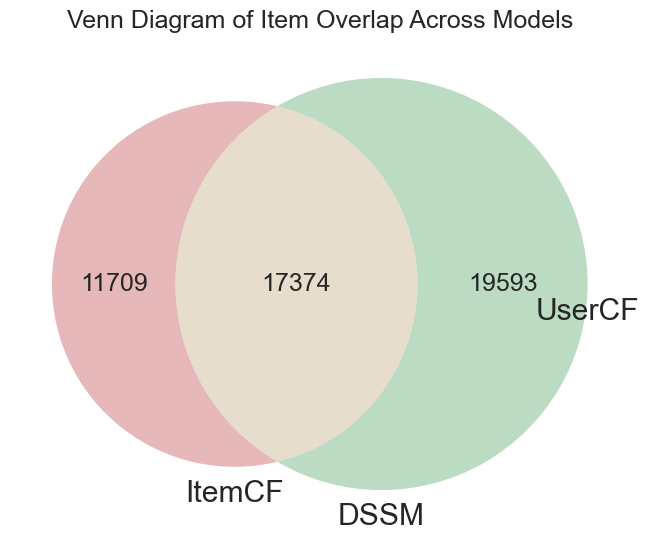

In [ ]:
# Calculate the counts for each region of the Venn diagram
only_ItemCF = len(items['ItemCF'] - items['DSSM'] - items['UserCF'])
only_DSSM = len(items['DSSM'] - items['ItemCF'] - items['UserCF'])
only_UserCF = len(items['UserCF'] - items['ItemCF'] - items['DSSM'])
ItemCF_and_DSSM_not_UserCF = len((items['ItemCF'] & items['DSSM']) - items['UserCF'])
ItemCF_and_UserCF_not_DSSM = len((items['ItemCF'] & items['UserCF']) - items['DSSM'])
DSSM_and_UserCF_not_ItemCF = len((items['DSSM'] & items['UserCF']) - items['ItemCF'])
all_three = len(items['ItemCF'] & items['DSSM'] & items['UserCF'])

# Define the counts for the Venn diagram regions
venn_labels = {
    '100': only_ItemCF,              # Only ItemCF
    '010': only_DSSM,                # Only DSSM
    '001': only_UserCF,              # Only UserCF
    '110': ItemCF_and_DSSM_not_UserCF,  # ItemCF and DSSM, not UserCF
    '101': ItemCF_and_UserCF_not_DSSM,  # ItemCF and UserCF, not DSSM
    '011': DSSM_and_UserCF_not_ItemCF,  # DSSM and UserCF, not ItemCF
    '111': all_three                 # All three models
}

# Create and display the Venn diagram
plt.figure(figsize=(8, 8))
venn3(subsets=venn_labels, set_labels=('ItemCF', 'DSSM', 'UserCF'))
plt.title("Venn Diagram of Item Overlap Across Models")
plt.show()